In [1]:
# creating spectrograms from all the files, and saving split labelled versions to disk ready for machine learning
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt

import os
import sys
import cPickle as pickle
import numpy as np
import time
import random 

from scipy.ndimage.interpolation import zoom

#from data_helpers import load_annotations

import nolearn
import nolearn.lasagne
import lasagne.layers

from lasagne.layers import InputLayer, DimshuffleLayer
from lasagne.layers import DenseLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import DropoutLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.nonlinearities import softmax, very_leaky_rectify as vlr
import theano

base = '/media/michael/Seagate/engage/alison_data/golden_set/'
annotation_pkl_dir = base + 'extracted/annotations/'
spec_pkl_dir = base + 'extracted/specs/'
log_dir = base + 'ml_runs/'

Using gpu device 0: GeForce GTX 770 (CNMeM is disabled, cuDNN 5004)
/home/michael/anaconda/lib/python2.7/site-packages/Theano-0.9.0.dev1-py2.7.egg/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
HWW = 15
SPEC_HEIGHT = 330

In [3]:
# create a class for the spectrograms, from which we can get minbatches of data
class SpecSampler(object):
    
    def _ensure_correct_shape_spec(self, spec):
        if spec.ndim == 2:
            return spec[None, ...]
        else:
            return spec
    
    def __init__(self, specs, labels, hww):       
        self.specs = np.vstack(self._ensure_correct_shape_spec(spec) for spec in specs)
        self.labels = labels
        self.hww = hww
    
    def _ensure_shape(self, X):
        if X.shape[2] < self.hww * 2:
            return np.pad(X, ((0, 0), (0, 0), (0, self.hww * 2 - X.shape[2])), 'constant')
        else:
            return X
    
    def sample(self, num_per_class, seed=None):
        
        tic = time.time()
        num_samples = num_per_class * 2
        channels = self.specs.shape[0]
        height = self.specs.shape[1]
        
        if seed is not None:
            np.random.seed(seed)

        X = np.zeros((num_samples, channels, height, self.hww*2), np.float32)
        y = np.zeros(num_samples) * np.nan
        count = 0
        tic = time.time()
        
        for cls in [0, 1]:
            possible_locs = np.where(self.labels==cls)[0]

            if len(possible_locs) >= num_per_class:
                sampled_locs = np.random.choice(possible_locs, num_per_class, replace=False)

                for loc in sampled_locs:
                    X[count] = self._ensure_shape(
                        self.specs[:, :, (loc-self.hww):(loc+self.hww)])
                    y[count] = cls
                    count += 1

        # remove ones we couldn't get
        to_remove = np.isnan(y)
        return X[~to_remove], y[~to_remove]
        
        
#ss = SpecSampler([np.log((0.001+ melspec))[None, :100, :]], {0: bio_zoomed}, 10)

In [4]:
# load data and make list of specsamplers
samplers = []

for fname in os.listdir(spec_pkl_dir):
    
    # load spectrogram and annotations
    spec = pickle.load(open(spec_pkl_dir + fname))[:SPEC_HEIGHT, :]
    annots, wav, sample_rate = pickle.load(
        open(annotation_pkl_dir + fname))
        
    # reshape annotations
    for classname in annots:
        factor = float(spec.shape[1]) / annots[classname].shape[0]
        annots[classname] = zoom(annots[classname], factor)
        
    # create sampler
    logspec = np.log(0.001 + spec)
    logspec_med = logspec - np.median(logspec, axis=1, keepdims=True)
    spec_stack = [logspec_med]#, np.random.rand(*logspec.shape)]
    ss = SpecSampler(spec_stack, annots['biotic'], HWW)
    samplers.append(ss)

In [5]:
class MyBatch(nolearn.lasagne.BatchIterator):
    def __iter__(self):
        bs = self.batch_size
        for sampler in self.X:
            xb, yb = sampler.sample(bs)
            xb = np.hstack((xb, (xb-xb.mean()) / xb.std() ))
            
            num = xb.shape[0]
            xb *= (1.0 + np.random.randn(num, 1, 1, 1) * 0.1)
            xb += np.random.randn(num, 1, 1, 1) * 0.05
            yield xb.astype(np.float32), yb.astype(np.int32)

            
class MyBatchTest(nolearn.lasagne.BatchIterator):
    def __iter__(self):
        bs = self.batch_size
        for sampler in self.X:
            xb, yb = sampler.sample(bs, seed=10)
            xb = np.hstack((xb, (xb-xb.mean()) / xb.std() ))
            yield xb.astype(np.float32), yb.astype(np.int32)

            
class MyTrainSplit(nolearn.lasagne.TrainSplit):
    # custom data split
    def __call__(self, data, Yb, net):
        return samplers[:20], samplers[20:], None, None

In [6]:
# from lasagne.nonlinearities import elu as vlr
from lasagne.nonlinearities import softmax, very_leaky_rectify as vlr
from lasagne.layers import batch_norm
net = {}
net['input'] = InputLayer((None, len(spec_stack)+1, SPEC_HEIGHT, HWW*2))

net['conv1_1'] = batch_norm(ConvLayer(net['input'], 80, (spec.shape[0] - 5, 6), nonlinearity=vlr))
net['pool1'] = PoolLayer(net['conv1_1'], pool_size=(4, 3), stride=(1, 3))
net['pool1'] = DropoutLayer(net['pool1'], p=0.5)
net['conv1_2'] = batch_norm(ConvLayer(net['pool1'], 80, (1, 3), nonlinearity=vlr))
net['pool2'] = PoolLayer(net['conv1_2'], pool_size=(1, 2), stride=(1, 1))
net['pool2'] = DropoutLayer(net['pool2'], p=0.5)

net['fc6'] = batch_norm(DenseLayer(net['pool2'], num_units=512, nonlinearity=vlr))
net['fc6'] = DropoutLayer(net['fc6'], p=0.5)
net['fc7'] = batch_norm(DenseLayer(net['fc6'], num_units=512, nonlinearity=vlr))
net['fc7'] = DropoutLayer(net['fc7'], p=0.5)
net['fc8'] = DenseLayer(net['fc7'], num_units=2, nonlinearity=None)
net['prob'] = NonlinearityLayer(net['fc8'], softmax)

net = nolearn.lasagne.NeuralNet(
    layers=net['prob'],
    max_epochs=5,
    update=lasagne.updates.nesterov_momentum,
    update_learning_rate=0.001,
    update_momentum=0.975,
    verbose=1,
    batch_iterator_train=MyBatch(128),
    batch_iterator_test=MyBatchTest(128),
    train_split=MyTrainSplit(None),
    check_input=False
)

In [7]:
net.fit(samplers, None)

# Neural Network with 1211138 learnable parameters

## Layer information

  #    name  size
---  ------  --------
  0          2x330x30
  1          80x6x25
  2          80x6x25
  3          80x6x25
  4          80x3x8
  5          80x3x8
  6          80x3x6
  7          80x3x6
  8          80x3x6
  9          80x3x5
 10          80x3x5
 11          512
 12          512
 13          512
 14          512
 15          512
 16          512
 17          512
 18          512
 19          2
 20          2

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  -----
      1       1.09661       0.79589      1.37784      0.65156  3.49s
      2       1.08500       0.75244      1.44197      0.66289  3.39s
      3       0.86090       0.67317      1.27887      0.64062  3.40s
      4       0.82909       0.68572      1.20908      0.65684  3.42s
      5       0.78620       0.68338      1.15045      0.65664  3.42s


NeuralNet(X_tensor_type=None,
     batch_iterator_test=<__main__.MyBatchTest object at 0x7f752371d190>,
     batch_iterator_train=<__main__.MyBatch object at 0x7f752370de90>,
     check_input=False, custom_epoch_scores=None, custom_scores=None,
     layers=[<lasagne.layers.special.NonlinearityLayer object at 0x7f752370de50>],
     loss=None, max_epochs=5, more_params={},
     objective=<function objective at 0x7f7523df4aa0>,
     objective_loss_function=<function categorical_crossentropy at 0x7f7530478b18>,
     on_batch_finished=[],
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x7f752371a830>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo instance at 0x7f752371a950>],
     regression=False,
     train_split=<__main__.MyTrainSplit object at 0x7f752371d210>,
     update=<function nesterov_momentum at 0x7f753048f6e0>,
     update_learning_rate=0.001, update_momentum=0.975,
     use_label_encoder=False, verbose=

<module 'matplotlib.pyplot' from '/home/michael/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

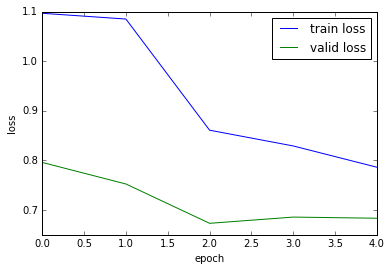

In [8]:
def plot_loss(net):
    train_loss = [row['train_loss'] for row in net.train_history_]
    valid_loss = [row['valid_loss'] for row in net.train_history_]
    plt.plot(train_loss, label='train loss')
    plt.plot(valid_loss, label='valid loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')
    return plt
plot_loss(net)

In [9]:
y = [0.197185359589, 0.518698018591, 0.581381482387, 0.664551736791, 0.699983182485]
x = [100, 500, 1000, 2500, 5000]
